In [2]:
!pip3 install catBoost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.8 MB 12 kB/s 


# Data research

Здесь мы создадим модель, предсказывающую потенциальный рейтинг рецепта, приготовленного из заданного набора ингредиентов. 

In [3]:
import pandas as pd
import numpy as np
import requests
# import json
import time
import seaborn
# from bs4 import BeautifulSoup
from collections import Counter
# from requests.auth import HTTPBasicAuth

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_val_predict
from sklearn import linear_model, metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from matplotlib import pyplot as plt
import pickle

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
with open("/content/gdrive/MyDrive/Python_DS/rush01/epi_r.csv") as file:
    df = pd.read_csv(file)

Посмотрим на дата фрейм, с которым мы будем работать. 

In [5]:
df.head()

,title,rating,calories,protein,fat,sodium,#cakeweek,#wasteless,22-minute meals,3-ingredient recipes,...,yellow squash,yogurt,yonkers,yuca,zucchini,cookbooks,leftovers,snack,snack week,turkey
0,"Lentil, Apple, and Turkey Wrap",2.500,426.0,30.0,7.0,559.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,Boudin Blanc Terrine with Red Onion Confit,4.375,403.0,18.0,23.0,1439.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Potato and Fennel Soup Hodge,3.750,165.0,6.0,7.0,165.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Mahi-Mahi in Tomato Olive Sauce,5.000,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Spinach Noodle Casserole,3.125,547.0,20.0,32.0,452.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
print(Counter(df.columns).most_common(5))
print(len(df.columns))
print(len(set(df.columns)))

[('title', 1), ('rating', 1), ('calories', 1), ('protein', 1), ('fat', 1)]
680
680


Посмотрим на размер нашего дата фрейма

In [7]:
print(df.shape)

(20052, 680)


Переименуем названия с неподходящим форматом

In [8]:
df.rename({'milk/cream':'milk',
           'sweet potato/yam':'sweet potato',
           'green onion/scallion': 'green onion',
           'cognac/armagnac':'cognac',
           'soup/stew': 'soup',
           'butterscotch/caramel':'caramel',
           'jam or jelly': 'jam',
           'condiment/spread': 'condiment',
           'soufflé/meringue': 'soufflé'}, axis=1, inplace=True)

Отбираем из названий столбцов названия ингредиентов

In [9]:
columns = ['title', 'rating', 'almond', 'amaretto', 
           'anchovy', 'apple', 'apple juice', 'apricot', 'artichoke', 'arugula', 'asian pear', 
           'asparagus', 'aspen', 'avocado', 'bacon', 'banana', 'barley', 'bean', 'beef', 'beef rib', 
           'beef shank', 'beef tenderloin', 'beer', 'beet', 'bell pepper', 'berry', 'biscuit', 'bitters', 
           'blackberry', 'blue cheese', 'blueberry', 'bourbon', 'bran', 'brandy', 'bread', 'brie', 'brisket', 
           'broccoli', 'broccoli rabe', 'brown rice', 'brussel sprout', 'bulgur', 'butter', 'buttermilk', 
           'butternut squash', 'caramel', 'cabbage', 'cake', 'candy', 'cantaloupe', 'caraway', 'carrot', 
           'cashew', 'cauliflower', 'caviar', 'celery', 'champagne', 'chard', 'chartreuse', 'cheddar', 
           'cheese', 'cherry', 'chestnut', 'chicken', 'chickpea', 'chile pepper', 'chili', 'chive', 
           'chocolate', 'cilantro', 'cinco de mayo', 'cinnamon', 'citrus', 'clam', 'coconut', 'cod', 
           'coffee', 'cognac', 'collard greens', 'cookies', 'coriander', 'corn', 'cornmeal', 'cottage cheese', 
           'couscous', 'crab', 'cranberry', 'cranberry sauce', 'cream cheese', 'cucumber', 
           'currant', 'curry', 'custard', 'dill', 'dried fruit', 'duck', 'egg', 'egg nog', 'eggplant', 
           'endive', 'escarole', 'fennel', 'feta', 'fish', 'flat bread', 'fortified wine', 'fritter', 
           'fruit juice', 'gin', 'ginger', 'goat cheese', 'goose', 'gouda', 'granola', 'grape', 'grapefruit', 
           'green bean', 'green onion', 'ground beef', 'ground lamb', 'guava', 'halibut', 'ham', 'hazelnut', 
           'honey', 'honeydew', 'horseradish', 'hot pepper', 'hummus', 'ice cream', 'iced coffee', 'iced tea', 
           'jam', 'jerusalem artichoke', 'kale', 'kiwi', 'kumquat', 'lamb', 'lamb chop', 'lamb shank', 'leek', 
           'lemon', 'lemon juice', 'lentil', 'lettuce', 'lima bean', 'lime', 'lime juice', 'liqueur', 'lobster', 
           'lychee', 'macadamia nut', 'mango', 'maple syrup', 'marsala', 'marshmallow', 'martini', 'mayonnaise', 
           'meat', 'meatball', 'melon', 'milk', 'mint', 'molasses', 'mozzarella', 'muffin', 'mushroom', 
           'mussel', 'mustard', 'mustard greens', 'nectarine', 'noodle', 'nut', 'oat', 'oatmeal', 'octopus', 
           'okra', 'olive', 'omelet', 'onion', 'orange', 'orange juice', 'oyster', 'pancake', 'papaya', 
           'parmesan', 'parsley', 'parsnip', 'passion fruit', 'pasta', 'pea', 'peach', 'peanut', 
           'peanut butter', 'pear', 'pecan', 'pepper', 'persimmon', 'pine nut', 'pineapple', 'pistachio', 
           'pizza', 'plantain', 'plum', 'poblano', 'pomegranate', 'pomegranate juice', 'poppy', 'pork', 
           'pork chop', 'pork rib', 'pork tenderloin', 'potato', 'potato salad', 'poultry', 'poultry sausage', 
           'pressure cooker', 'prosciutto', 'prune', 'pumpkin', 'quail', 'quiche', 'quinoa', 'rabbit', 
           'rack of lamb', 'radicchio', 'radish', 'raisin', 'raspberry', 'red wine', 'rhubarb', 'rice', 
           'ricotta', 'rum', 'rutabaga', 'rye', 'sake', 'salad', 'salmon', 'salsa', 'sangria', 'sardine', 
           'sausage', 'scallop', 'scotch', 'seafood', 'semolina', 'sesame', 'sesame oil', 'shellfish', 
           'sherry', 'shrimp', 'snapper', 'sorbet', 'soup', 'sour cream', 'soy', 'soy sauce', 'sparkling wine', 
           'spinach', 'squid', 'steak', 'strawberry', 'sweet potato', 'swiss cheese', 'swordfish', 'taco', 
           'tamarind', 'tangerine', 'tapioca', 'tea', 'tequila', 'tilapia', 'tofu', 'tomatillo', 'tomato', 
           'tortillas', 'trout', 'tuna', 'turnip', 'vanilla', 'veal', 'venison', 'vermouth', 'vinegar', 
           'vodka', 'waffle', 'walnut', 'wasabi', 'watercress', 'watermelon', 'whiskey', 'white wine', 
           'whole wheat', 'wild rice', 'wine', 'yogurt', 'yuca', 'zucchini', 'turkey']

In [10]:
data = df[columns]
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20052 entries, 0 to 20051
Columns: 300 entries, title to turkey
dtypes: float64(299), object(1)
memory usage: 45.9+ MB


In [11]:
data.to_csv('/content/gdrive/MyDrive/Python_DS/rush01/epi_r_short.csv')

In [12]:
for i in range(1, len(data.columns)):
    if np.sum(data[data.columns[i]]) == 0:
        print(i, data.columns[i], np.sum(data[data.columns[i]]))

In [13]:
print(data.columns)
data.info()

Index(['title', 'rating', 'almond', 'amaretto', 'anchovy', 'apple',
       'apple juice', 'apricot', 'artichoke', 'arugula',
       ...
       'watermelon', 'whiskey', 'white wine', 'whole wheat', 'wild rice',
       'wine', 'yogurt', 'yuca', 'zucchini', 'turkey'],
      dtype='object', length=300)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20052 entries, 0 to 20051
Columns: 300 entries, title to turkey
dtypes: float64(299), object(1)
memory usage: 45.9+ MB


Посмотрим, какие продукты встречаются чаще

In [14]:
data.iloc[:,6:].sum().sort_values(ascending=False)[:20]

onion        2238.0
tomato       2140.0
milk         1995.0
egg          1768.0
salad        1516.0
cheese       1355.0
chicken      1344.0
soup         1164.0
ginger       1146.0
potato       1128.0
lemon        1104.0
pasta         968.0
fish          936.0
pork          928.0
nut           905.0
citrus        863.0
chocolate     855.0
mushroom      843.0
orange        837.0
beef          811.0
dtype: float64

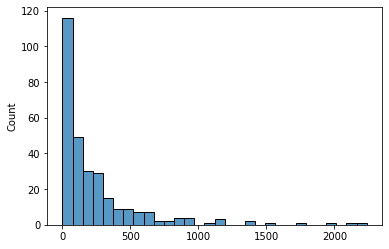

In [15]:
seaborn.histplot(data.iloc[:,6:].sum(axis=0))

# Обучение

Preproccesing

In [17]:
X = data.iloc[:,2:]
Y = data.rating
print(X.head())
print(Y.head())
X.shape

   almond  amaretto  anchovy  apple  apple juice  apricot  artichoke  arugula  \
0     0.0       0.0      0.0    1.0          0.0      0.0        0.0      0.0   
1     0.0       0.0      0.0    0.0          0.0      0.0        0.0      0.0   
2     0.0       0.0      0.0    0.0          0.0      0.0        0.0      0.0   
3     0.0       0.0      0.0    0.0          0.0      0.0        0.0      0.0   
4     0.0       0.0      0.0    0.0          0.0      0.0        0.0      0.0   

   asian pear  asparagus  ...  watermelon  whiskey  white wine  whole wheat  \
0         0.0        0.0  ...         0.0      0.0         0.0          0.0   
1         0.0        0.0  ...         0.0      0.0         0.0          0.0   
2         0.0        0.0  ...         0.0      0.0         0.0          0.0   
3         0.0        0.0  ...         0.0      0.0         0.0          0.0   
4         0.0        0.0  ...         0.0      0.0         0.0          0.0   

   wild rice  wine  yogurt  yuca  zucc

(20052, 298)

In [18]:
def crossval(n_splits, X, y, model):
  train_data, test_data, train_labels, test_labels = train_test_split(X, y, test_size = 0.2, random_state=21)

  ft_m = model.fit(train_data, train_labels)
  scores = cross_val_score(model, train_data, train_labels, cv=n_splits)
  scores_test = cross_val_score(model, test_data, test_labels, cv=n_splits)
  predict = cross_val_predict(ft_m, test_data, test_labels, cv=n_splits)
  accuracy = metrics.mean_squared_error(test_labels, predict)

  for i in range(0, len(scores)):
    print(f'train - {scores[i]} | test - {scores_test[i]}')
  print(f'Average RMSE on crossval is {accuracy}\n')

  plt.scatter(test_labels, predict, cmap='Accent')
  plt.xlabel('x')
  plt.ylabel('y')
  plt.show()

train - -1.135812740108944e+24 | test - -1.379344125953112e+22
train - -2.2536948549339707e+21 | test - -14158430.419512946
train - -7.059847364475333e+20 | test - -0.004456749529914816
train - -1.6417820515958726e+24 | test - -0.07357682049691139
train - -4.169019469128275e+22 | test - -6.625917774692889e+18
train - -2.330752994030583e+22 | test - -7.152183180025517e+23
Average RMSE on crossval is 1.729534547279777e+23



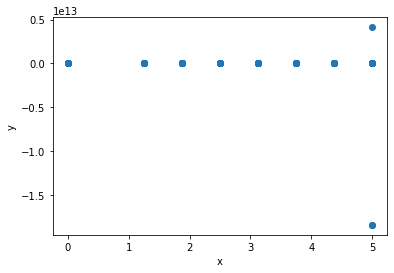

In [19]:
regr = linear_model.LinearRegression()
crossval(6, X, Y, regr)

train - -0.3570228944152849 | test - -0.7747053693942823
train - -0.4732504829535751 | test - -1.3951987024722077
train - -0.5203032289862011 | test - -0.749509958716533
train - -0.44931237163159476 | test - -0.7284707956336471
train - -0.41712726700474057 | test - -0.3943332967180886
train - -0.47685751431803913 | test - -0.8632011664898882
Average RMSE on crossval is 3.0382730411741323



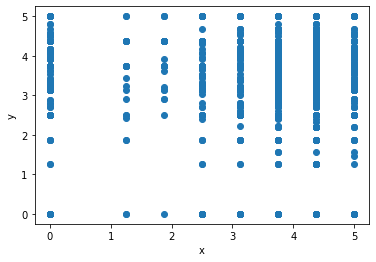

In [20]:
treeRegr = DecisionTreeRegressor(random_state=21)
crossval(6, X, Y, treeRegr)

train - 0.015982893969600953 | test - -0.09095658742788881
train - -0.011890162698594331 | test - -0.2836778963070907
train - -0.05738221492983708 | test - -0.18157786951326416
train - 0.010077937454495589 | test - -0.18723906371078702
train - 0.012268793267335654 | test - -0.04814658166413288
train - -0.01263919408973524 | test - -0.22232010618498
Average RMSE on crossval is 1.9765582305542595



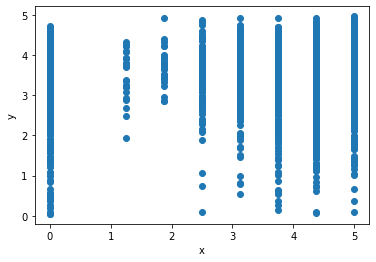

In [21]:
rFrstRegr = RandomForestRegressor(random_state = 21)
crossval(6, X, Y, rFrstRegr)

Streaming output truncated to the last 5000 lines.
12:	learn: 1.3135757	total: 42.7ms	remaining: 3.24s
13:	learn: 1.3127952	total: 45.3ms	remaining: 3.19s
14:	learn: 1.3117562	total: 48.1ms	remaining: 3.16s
15:	learn: 1.3111003	total: 50.8ms	remaining: 3.12s
16:	learn: 1.3102083	total: 53.4ms	remaining: 3.09s
17:	learn: 1.3093998	total: 56.6ms	remaining: 3.09s
18:	learn: 1.3086755	total: 59.2ms	remaining: 3.06s
19:	learn: 1.3075692	total: 61.7ms	remaining: 3.02s
20:	learn: 1.3067787	total: 64.2ms	remaining: 2.99s
21:	learn: 1.3058185	total: 66.7ms	remaining: 2.96s
22:	learn: 1.3049780	total: 68.7ms	remaining: 2.92s
23:	learn: 1.3042159	total: 71.2ms	remaining: 2.9s
24:	learn: 1.3035575	total: 73.7ms	remaining: 2.87s
25:	learn: 1.3028027	total: 76.1ms	remaining: 2.85s
26:	learn: 1.3022551	total: 78.6ms	remaining: 2.83s
27:	learn: 1.3012466	total: 81.1ms	remaining: 2.81s
28:	learn: 1.3005535	total: 83.7ms	remaining: 2.8s
29:	learn: 1.3000488	total: 86.1ms	remaining: 2.78s
30:	learn: 1.29

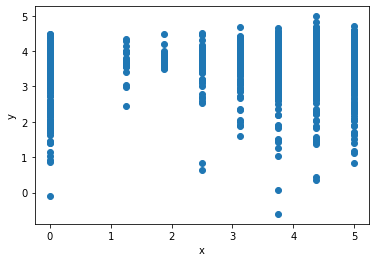

In [22]:
catBoost = CatBoostRegressor(random_state = 21)
crossval(6, X, Y, catBoost)

In [23]:
train_data, test_data, train_labels, test_labels = train_test_split(X, Y, test_size = 0.2, random_state=21)

naive_prediction = np.zeros(Y.shape) + Y.mean()
print('Naive prediction for full set: ', metrics.mean_squared_error(Y, naive_prediction))
naive_prediction_test = np.zeros(test_labels.shape) + Y.mean()
print('Naive prediction for test set: ', metrics.mean_squared_error(test_labels, naive_prediction_test))

Naive prediction for full set:  1.797731922584762
Naive prediction for test set:  1.708845744553229


In [25]:
catBoost = CatBoostRegressor(random_state = 21)
catBoost.fit(X, Y)
with open('/content/gdrive/MyDrive/DS_Piscine/Rash01/finalized_regression.sav', 'wb') as fout:
  pickle.dump(catBoost, fout)

Learning rate set to 0.065754
0:	learn: 1.3364498	total: 7.02ms	remaining: 7.01s
1:	learn: 1.3327147	total: 13.9ms	remaining: 6.94s
2:	learn: 1.3295269	total: 20.5ms	remaining: 6.81s
3:	learn: 1.3261871	total: 27.2ms	remaining: 6.78s
4:	learn: 1.3237346	total: 34ms	remaining: 6.76s
5:	learn: 1.3215721	total: 40.5ms	remaining: 6.7s
6:	learn: 1.3193465	total: 47ms	remaining: 6.67s
7:	learn: 1.3170511	total: 53.6ms	remaining: 6.65s
8:	learn: 1.3152929	total: 60.3ms	remaining: 6.64s
9:	learn: 1.3134379	total: 67ms	remaining: 6.63s
10:	learn: 1.3119547	total: 73.8ms	remaining: 6.64s
11:	learn: 1.3104498	total: 80.3ms	remaining: 6.61s
12:	learn: 1.3092820	total: 86.9ms	remaining: 6.6s
13:	learn: 1.3081078	total: 93.6ms	remaining: 6.59s
14:	learn: 1.3071253	total: 100ms	remaining: 6.59s
15:	learn: 1.3061589	total: 109ms	remaining: 6.67s
16:	learn: 1.3053556	total: 115ms	remaining: 6.64s
17:	learn: 1.3046697	total: 121ms	remaining: 6.61s
18:	learn: 1.3036097	total: 128ms	remaining: 6.58s
19:	l

# Classificator

In [26]:
df_clf = data
df_clf = df_clf.assign(r_rating = round(df_clf.rating, 0))

In [27]:
def clf_rating (row):
  if row['r_rating'] < 2:
    return 0
  if row['r_rating'] in range(2,4):
    return 1
  if row['r_rating'] in range(4,6):
    return 2  
df_clf['clf_rating'] = df_clf.apply(lambda row: clf_rating(row), axis =1)
df_clf.head()

,title,rating,almond,amaretto,anchovy,apple,apple juice,apricot,artichoke,arugula,...,white wine,whole wheat,wild rice,wine,yogurt,yuca,zucchini,turkey,r_rating,clf_rating
0,"Lentil, Apple, and Turkey Wrap",2.500,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1
1,Boudin Blanc Terrine with Red Onion Confit,4.375,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,2
2,Potato and Fennel Soup Hodge,3.750,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,2
3,Mahi-Mahi in Tomato Olive Sauce,5.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,2
4,Spinach Noodle Casserole,3.125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1


In [31]:
X = df_clf.iloc[:,2:len(df_clf.columns) - 2].values
Y = df_clf.clf_rating.values
print(X)
print(Y)

[[0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[1 2 2 ... 2 2 2]


In [32]:
df_clf_count = df_clf.groupby(['clf_rating']).count()
df_clf_count

,title,rating,almond,amaretto,anchovy,apple,apple juice,apricot,artichoke,arugula,...,whiskey,white wine,whole wheat,wild rice,wine,yogurt,yuca,zucchini,turkey,r_rating
clf_rating,,,,,,,,,,,,,,,,,,,,,
0,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000,...,2000,2000,2000,2000,2000,2000,2000,2000,2000,2000
1,2145,2145,2145,2145,2145,2145,2145,2145,2145,2145,...,2145,2145,2145,2145,2145,2145,2145,2145,2145,2145
2,15907,15907,15907,15907,15907,15907,15907,15907,15907,15907,...,15907,15907,15907,15907,15907,15907,15907,15907,15907,15907


In [33]:
def crossval_clf(n_splits, X, y, model):
  train_data, test_data, train_labels, test_labels = train_test_split(X, y, test_size = 0.2, random_state=21)

  ft_m = model.fit(train_data, train_labels)
  scores = cross_val_score(model, train_data, train_labels, cv=n_splits)
  scores_test = cross_val_score(model, test_data, test_labels, cv=n_splits)
  predict = cross_val_predict(ft_m, test_data, test_labels, cv=n_splits)
  accuracy = metrics.accuracy_score(test_labels,predict)

  for i in range(0, len(scores)):
    print(f'train - {scores[i]} | test - {scores_test[i]}')
  print(f'Average mean accuracy on crossval is {accuracy}\n')

  options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),]
  for title, normalize in options:
    display = ConfusionMatrixDisplay.from_estimator(
        ft_m,
        test_data,
        test_labels,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    display.ax_.set_title(title)

    print(title)
    print(display.confusion_matrix)

  plt.show()

train - 0.7816005983545251 | test - 0.8011958146487295
train - 0.7909498878085266 | test - 0.7802690582959642
train - 0.7819745699326851 | test - 0.7937219730941704
train - 0.7815188926300037 | test - 0.7679640718562875
train - 0.7837635615413393 | test - 0.7799401197604791
train - 0.7856341189674523 | test - 0.7904191616766467
Average mean accuracy on crossval is 0.7855896285215657

Confusion matrix, without normalization
[[  83    2  287]
 [  16    2  421]
 [ 112    5 3083]]
Normalized confusion matrix
[[0.22311828 0.00537634 0.77150538]
 [0.03644647 0.00455581 0.95899772]
 [0.035      0.0015625  0.9634375 ]]


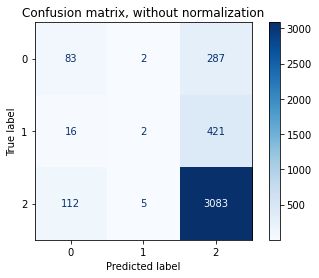

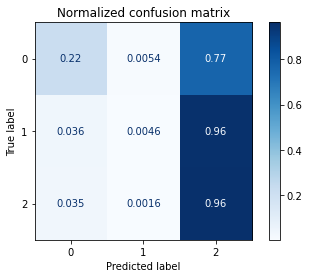

In [34]:
NB = MultinomialNB()
crossval_clf(6, X, Y, NB)

train - 0.7329842931937173 | test - 0.7443946188340808
train - 0.7210172026925954 | test - 0.7279521674140508
train - 0.7135377711293942 | test - 0.71898355754858
train - 0.7182940516273849 | test - 0.7155688622754491
train - 0.720164609053498 | test - 0.7290419161676647
train - 0.7055742611298167 | test - 0.7350299401197605
Average mean accuracy on crossval is 0.7284966342557966

Confusion matrix, without normalization
[[ 141   27  204]
 [  45   93  301]
 [ 288  215 2697]]
Normalized confusion matrix
[[0.37903226 0.07258065 0.5483871 ]
 [0.10250569 0.2118451  0.6856492 ]
 [0.09       0.0671875  0.8428125 ]]


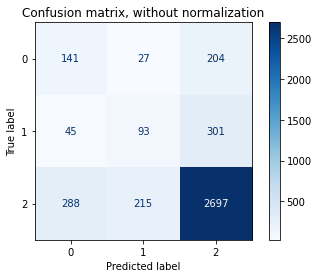

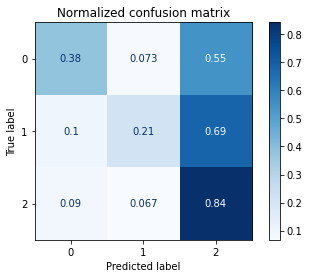

In [35]:
RF = RandomForestClassifier(random_state=21, class_weight='balanced', oob_score=True)
crossval_clf(6, X, Y, RF)

train - 0.7550486163051608 | test - 0.7623318385650224
train - 0.7595362752430815 | test - 0.772795216741405
train - 0.7348541510845176 | test - 0.7563527653213752
train - 0.7429854096520763 | test - 0.7080838323353293
train - 0.7500935278713057 | test - 0.7320359281437125
train - 0.7448559670781894 | test - 0.7350299401197605
Average mean accuracy on crossval is 0.7444527549239591

Confusion matrix, without normalization
[[  70   16  286]
 [  30   30  379]
 [ 173  107 2920]]
Normalized confusion matrix
[[0.18817204 0.04301075 0.7688172 ]
 [0.06833713 0.06833713 0.86332574]
 [0.0540625  0.0334375  0.9125    ]]


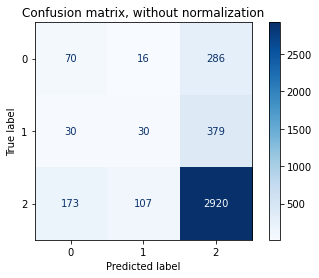

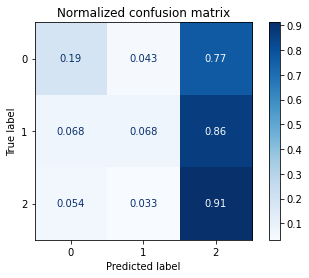

In [36]:
KNC = KNeighborsClassifier()
crossval_clf(6, X, Y, KNC)

Streaming output truncated to the last 5000 lines.
20:	learn: 0.6482878	total: 92.3ms	remaining: 4.3s
21:	learn: 0.6455068	total: 96.8ms	remaining: 4.3s
22:	learn: 0.6427824	total: 101ms	remaining: 4.3s
23:	learn: 0.6396920	total: 105ms	remaining: 4.29s
24:	learn: 0.6375937	total: 110ms	remaining: 4.28s
25:	learn: 0.6360162	total: 115ms	remaining: 4.32s
26:	learn: 0.6345773	total: 123ms	remaining: 4.45s
27:	learn: 0.6329147	total: 136ms	remaining: 4.73s
28:	learn: 0.6313480	total: 142ms	remaining: 4.76s
29:	learn: 0.6301710	total: 146ms	remaining: 4.73s
30:	learn: 0.6292473	total: 150ms	remaining: 4.7s
31:	learn: 0.6278820	total: 155ms	remaining: 4.68s
32:	learn: 0.6267542	total: 159ms	remaining: 4.66s
33:	learn: 0.6259985	total: 165ms	remaining: 4.67s
34:	learn: 0.6250711	total: 169ms	remaining: 4.67s
35:	learn: 0.6244427	total: 174ms	remaining: 4.65s
36:	learn: 0.6237778	total: 180ms	remaining: 4.67s
37:	learn: 0.6229099	total: 188ms	remaining: 4.76s
38:	learn: 0.6223574	total: 200ms

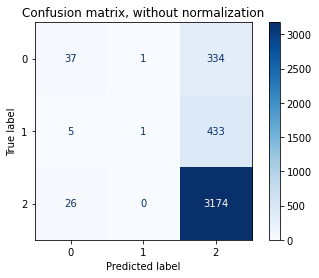

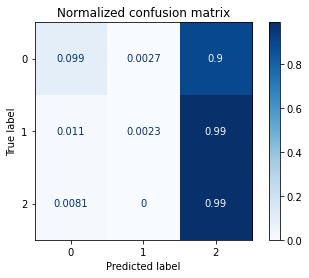

In [37]:
catBoost_clf = CatBoostClassifier( iterations=1000, random_state=21)
crossval_clf(6, X, Y, catBoost_clf)

In [38]:
RF_fin = RandomForestClassifier(random_state=21, class_weight='balanced', oob_score=True)
RF_fin.fit(X, Y)
with open('/content/gdrive/MyDrive/DS_Piscine/Rash01/finalized_classifier.sav', 'wb') as fout:
  pickle.dump(RF_fin, fout)